## HW6: Reaction-Diffusion Systems
Anna Dodson

Dec 6, 2024

The λ - ω reaction-diffusion system describes the interaction of chemical species through reaction and diffusion. The equations are given by:

$$
\frac{\partial U}{\partial t} = \lambda(A)U - \omega(A)V + D_1 \nabla^2 U,
$$

$$
\frac{\partial V}{\partial t} = \omega(A)U + \lambda(A)V + D_2 \nabla^2 V,
$$

Which we can set up as a system of equations:

$$
\frac{d}{dt}
\begin{bmatrix}
    U \\
    V
\end{bmatrix}
=
\begin{bmatrix}
    \lambda(A)U - \omega(A)V + D_1 \nabla^2 U \\
    \omega(A)U + \lambda(A)V + D_2 \nabla^2 V
\end{bmatrix}.
$$

#### Boundary Conditions

1. **Periodic Boundary Conditions**:  
   The solution is periodic in both x and y directions
2. **No-Flux Boundary Conditions**:  
   $$
   \frac{\partial U}{\partial n} = \frac{\partial V}{\partial n} = 0 \quad \text{on the boundaries.}
   $$


In [1]:
# Part 1

# λ(A)=1−A^2 ,ω(A)=−βA^2, A^2 = U^2 + V^2
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

# Parameters
n = 64  # Grid points for periodic
Lx, Ly = 20, 20  # Domain size
beta = 1
D1, D2 = 0.1, 0.1
x = np.linspace(-Lx / 2, Lx / 2, n, endpoint=False)
y = np.linspace(-Ly / 2, Ly / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)

In [2]:
# Initial conditions (spiral)
theta = np.angle(X + 1j * Y)
R = np.sqrt(X**2 + Y**2)
U0 = np.tanh(R) * np.cos(theta - R)
V0 = np.tanh(R) * np.sin(theta - R)
U0_hat = fft2(U0)
V0_hat = fft2(V0)

# Compute Fourier wavenumbers
kx = 2 * np.pi * np.fft.fftfreq(n, d=Lx / n)
ky = 2 * np.pi * np.fft.fftfreq(n, d=Ly / n)
KX, KY = np.meshgrid(kx, ky)
k2 = KX**2 + KY**2

def lambda_A(A2):
    return 1 - A2

def omega_A(A2, beta):
    return -beta * A2

# Right-hand side for periodic boundaries
def rhs_periodic(t, UV):
    U = UV[:n**2].reshape((n, n))
    V = UV[n**2:].reshape((n, n))
    A2 = U**2 + V**2
    L = lambda_A(A2)
    W = omega_A(A2, beta=beta)
    
    # Compute RHS using FFT
    U_hat = fft2(U)
    V_hat = fft2(V)
    # Extract only the real part
    d2U_real = np.real(ifft2(-k2 * U_hat))
    d2V_real = np.real(ifft2(-k2 * V_hat))
    
    # Time derivatives
    Ut = L * U - W * V + D1 * d2U_real
    Vt = W * U + L * V + D2 * d2V_real
    return np.concatenate([Ut.ravel(), Vt.ravel()])

# System of equations in Fourier space
def rhs_periodic_fourierdomain(t, UV_hat):
    U_hat = UV_hat[:n**2].reshape((n, n))
    V_hat = UV_hat[n**2:].reshape((n, n))
    
    # Compute A^2 = U^2 + V^2
    # need to recover the original U, V to get A2
    U = ifft2(U_hat)
    V = ifft2(V_hat)
    A2 = (U)**2 + (V)**2
    
    # Reaction terms
    lam_A = lambda_A(A2)
    omg_A = omega_A(A2, beta)

    d2U_hat = -k2 * U_hat
    d2V_hat = -k2 * V_hat
    
    # Now get our derivative terms (using the Fourier transformed Laplacian)
    du_hat_dt = np.fft.fft2((lam_A * U - omg_A * V)) + D1 * d2U_hat
    dv_hat_dt = np.fft.fft2((omg_A * U + lam_A * V)) + D2 * d2V_hat
    
    return np.concatenate([du_hat_dt.flatten(), dv_hat_dt.flatten()])


# Solve using solve_ivp
T = 4
tspan = (0, T)
dt = .5
t_eval = np.arange(0, T + dt, dt)
UV0 = np.concatenate([U0.ravel(), V0.ravel()])
# For some reason we want this stuff in the fourier domain
# I already wrote the solution in the real domain, so we need to write another method which starts with IC in the fourier domain
sol_periodic_real = solve_ivp(rhs_periodic, tspan, UV0, t_eval=t_eval, method='RK45')

# fourier version
UV0_hat = np.concatenate([U0_hat.flatten(), V0_hat.flatten()])
# Solve the system in Fourier space
sol_periodic_fourierdomain = solve_ivp(rhs_periodic_fourierdomain, tspan, UV0_hat, t_eval=t_eval, method='RK45')

In [3]:
A1 = sol_periodic_fourierdomain.y[:n**2]

MovieWriter ffmpeg unavailable; using Pillow instead.


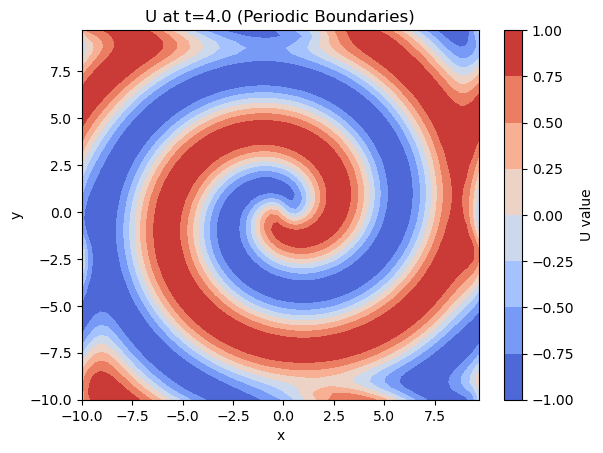

In [4]:
from matplotlib.animation import FuncAnimation

# Plot results for periodic boundaries
# for i, t in enumerate(t_eval):
#     U = sol_periodic.y[:n**2, i].reshape((n, n))
#     plt.figure()
#     plt.contourf(X, Y, U, cmap='coolwarm')
#     plt.title(f'U at t={t} (Periodic Boundaries)') 
#     plt.colorbar()
#     plt.show()

# Extract U data for all time steps
U_hat_data = sol_periodic_fourierdomain.y[:n**2, :].reshape((n, n, -1))  # Reshape to (n, n, time steps)

# Set up the figure and axis
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, np.real(np.fft.ifft2(U_hat_data[:, :, 0])), cmap='coolwarm')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('U value')
ax.set_title(f'U at t={t_eval[0]} (Periodic Boundaries)')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Update function for animation
def update(frame):
    ax.clear()
    contour = ax.contourf(X, Y, np.real(np.fft.ifft2(U_hat_data[:, :, frame])), cmap='coolwarm')
    rounded_time = round(t_eval[frame], 4)  # Round to 4 decimal points
    ax.set_title(f'U at t={rounded_time} (Periodic Boundaries)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return contour

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), interval=200)  # Adjust interval as needed

# Save or display the animation
ani.save('periodic_boundaries_animation.gif', fps=10)  # Save as a gif
plt.show()

# Repeat 


In [5]:
# For the submission, we don't need the animation, and T/t_span is reduced.
T = 4
tspan = (0, T)
dt = .5
t_eval = np.arange(0, T + dt, dt)
UV0 = np.concatenate([U0.ravel(), V0.ravel()])
sol_periodic = solve_ivp(rhs_periodic, tspan, UV0, t_eval=t_eval, method='RK45')

In [6]:
# def cheb(n_cheb):
#     if n_cheb < 2:
#         raise ValueError("n must be at least 2")
    
#     # Chebyshev points
#     x = np.cos(np.pi * np.arange(n_cheb) / (n_cheb - 1))
    
#     # Weights
#     c = np.ones(n)
#     c[0] = 2
#     c[-1] = 2
#     c = c * (-1) ** np.arange(n_cheb)
    
#     # Differentiation matrix
#     X = np.tile(x, (n_cheb, 1))
#     dX = X - X.T
#     D = (c[:, None] / c[None, :]) / dX  # Compute off-diagonal entries
#     np.fill_diagonal(D, 0)  # Set diagonal to 0
#     D -= np.diag(np.sum(D, axis=1))  # Correct diagonal entries
    
#     return D, x

In [7]:
n_cheb = 30

# Chebyshev differentiation matrix is defined as, for Chebyshev points xj = cos(jpi/n)
# The matrix Djk is given as 
# { cj/ck * (-1)^j+k/(xj-xk), j\neqk 
# { -xj/(2*(1-xj^2)), j=k \neq 0 or N
# { (2N^2 + 1)/6, j = k = 0
# { -(2N^2 + 1)/6, j = k = N
def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = np.arange(0,N+1)
		x = np.cos(np.pi*n/N).reshape(N+1,1) 
		c = (np.hstack(([2.], np.ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = np.tile(x,(1,N+1))
		dX = X - X.T
		D = np.dot(c,1./c.T)/(dX+np.eye(N+1))
		D -= np.diag(np.sum(D.T,axis=0))
	return D, x.reshape(N+1)

D, x_cheb = cheb(n_cheb)
D[n_cheb, :] = 0
D[0, :] = 0
# Second Derivative Matrix
Dxx = np.dot(D, D)/((Lx/2))**2
print(Dxx.shape)
I = np.eye(len(Dxx))
Lap_2D = np.kron(I, Dxx) + np.kron(Dxx, I)  # 2D Laplacian
print(Lap_2D.shape)

# Rescale to [-1, 1]
# D, x_cheb = cheb(n_cheb-1) 
# D = D / (Lx/2) # scaling it to the domain (-1, 1)
# D[n_cheb-1, :] = 0
# D[0, :] = 0 # no flux BCs
# D2 = np.dot(D, D)  # Second derivative matrix (Laplacian) in 1D
# print(D2.shape)
# I = np.eye(len(Dxx))
# L = kron(I, Dxx) + kron(Dxx, I) 
# # we actually won't need this - U and V laplacian are computed later
# Lap_2D = np.kron(D2, np.eye(len(D2))) + np.kron(np.eye(len(D2)), D2)
# print(Lap_2D.shape)

# Initial Conditions on Chebyshev grid
x = x_cheb * (Lx/2)
y = x_cheb * (Lx/2)
X, Y = np.meshgrid(x, y)
print(x.shape)
theta = np.angle(X + 1j * Y)
R = np.sqrt(X**2 + Y**2)
U0 = np.tanh(R) * np.cos(theta - R)
print(U0.shape)
V0 = np.tanh(R) * np.sin(theta - R)

# Right-hand side for no-flux boundaries
def rhs_noflux(t, UV):
    U = UV[:(n_cheb+1)**2]
    V = UV[(n_cheb+1)**2:]
    A2 = U**2 + V**2
    L = lambda_A(A2)
    W = omega_A(A2, beta)
    
    # Compute first derivatives in Chebyshev space
    LapU = np.dot(Lap_2D, U)
    LapV = np.dot(Lap_2D, V)
    
    # Time derivatives
    Ut = L * U - W * V + D1 * LapU
    Vt = W * U + L * V + D2 * LapV
    return np.concatenate([Ut.ravel(), Vt.ravel()])

# Solve using solve_ivp
UV0_cheb = np.concatenate([U0.ravel(), V0.ravel()])
print(t_eval)
sol_noflux = solve_ivp(rhs_noflux, tspan, UV0_cheb, t_eval=t_eval, method='RK45')

(31, 31)
(961, 961)
(31,)
(31, 31)
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


MovieWriter ffmpeg unavailable; using Pillow instead.


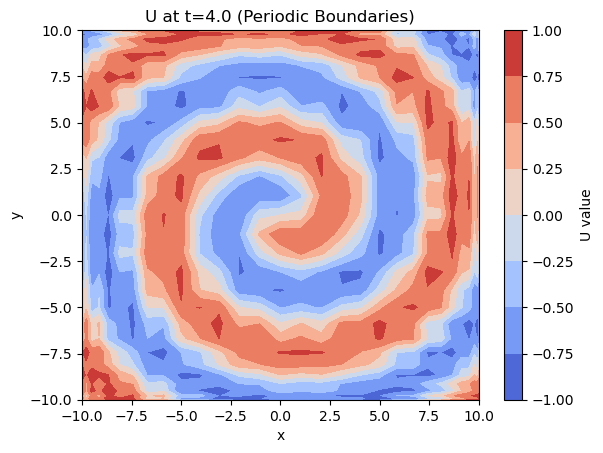

In [10]:
# Extract U data for all time steps
U_data = sol_noflux.y[:(n_cheb+1)**2, :].reshape((n_cheb+1, n_cheb+1, -1))  # Reshape to (n, n, time steps)

# Set up the figure and axis
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, (U_data[:, :, 0]), cmap='coolwarm')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('U value')
ax.set_title(f'U at t={t_eval[0]} (Periodic Boundaries)')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Update function for animation
def update(frame):
    ax.clear()
    contour = ax.contourf(X, Y, U_data[:, :, frame], cmap='coolwarm')
    rounded_time = round(t_eval[frame], 4)  # Round to 4 decimal points
    ax.set_title(f'U at t={rounded_time} (Periodic Boundaries)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return contour

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), interval=200)  # Adjust interval as needed

# Save or display the animation
ani.save('chebyshev_animation.gif', fps=10)  # Save as a gif
plt.show()


In [12]:
A2 = sol_noflux.y
print(A2.shape)

(1922, 9)
